# Classificação dos pokemons inicias da primeira geração

Alexandre Borges Baccarini Júnior - 2515520  
Leonardo - 25
Mateus - 25

## 1. Instalação e Importação de Bibliotecas

Execute a célula abaixo apenas uma vez para instalar as dependências necessárias.

In [ ]:
# Instale as bibliotecas necessárias (execute apenas uma vez)
%pip install numpy pandas Pillow scikit-learn keras imblearn scikit-image

## 2. Definição dos Descritores e Funções de Extração

Funções para extração de características manuais (LBP, LPQ) e profundas (VGG16).

In [17]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from typing import Literal
from skimage.feature import local_binary_pattern
from scipy.signal import convolve2d
from scipy.spatial.distance import cdist

def lbp(image: np.ndarray, 
        P: int = 8, 
        R: int = 2, 
        method: Literal['default', 'ror', 'uniform', 'nri_uniform', 'var'] = 'nri_uniform'):
    assert isinstance(image, np.ndarray) and len(image.shape) == 2
    desc = local_binary_pattern(image, P, R, method=method)
    n_bins = int(desc.max() + 1)
    hist, _ = np.histogram(desc, density=True, bins=n_bins, range=(0, n_bins))
    return hist

def lpq(img, winSize=7, decorr=1, mode='nh'):
    rho = 0.90
    STFTalpha = 1/winSize
    convmode = 'valid'
    
    img = np.float64(img)
    r = (winSize-1)/2
    x = np.arange(-r, r+1)[np.newaxis]
    
    # STFT filters
    w0 = np.ones_like(x)
    w1 = np.exp(-2*np.pi*x*STFTalpha*1j)
    w2 = np.conj(w1)
    
    # Filter responses
    filterResp1 = convolve2d(convolve2d(img, w0.T, convmode), w1, convmode)
    filterResp2 = convolve2d(convolve2d(img, w1.T, convmode), w0, convmode)
    filterResp3 = convolve2d(convolve2d(img, w1.T, convmode), w1, convmode)
    filterResp4 = convolve2d(convolve2d(img, w1.T, convmode), w2, convmode)
    
    freqResp = np.dstack([filterResp1.real, filterResp1.imag,
                         filterResp2.real, filterResp2.imag,
                         filterResp3.real, filterResp3.imag,
                         filterResp4.real, filterResp4.imag])
    
    if decorr == 1:
        pass
    
    # Quantization and LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis, np.newaxis, :]
    LPQdesc = ((freqResp > 0) * (2**inds)).sum(2)
    
    if mode == 'nh' or mode == 'h':
        LPQdesc = np.histogram(LPQdesc.flatten(), range(257))[0]
    if mode == 'nh':
        LPQdesc = LPQdesc / LPQdesc.sum()
    
    return LPQdesc

def extract_handcrafted_features(directory, descriptor='lbp', **kwargs):
    """Extract features using handcrafted descriptors"""
    features = []
    labels = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = os.path.join(directory, filename)
            # Corrigir para pegar o nome da classe (personagem)
            label = os.path.basename(os.path.dirname(directory))
            try:
                image = Image.open(img_path).convert('L')  # Grayscale
                image = np.array(image)
                
                if descriptor == 'lbp':
                    feat = lbp(image, **kwargs)
                elif descriptor == 'lpq':
                    feat = lpq(image, **kwargs)
                
                features.append(feat)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    return features, labels

from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.decomposition import PCA

def extract_deep_features(directory, target_size=(224, 224), pca_components=None, pca_model=None):
    """Extrai características profundas usando VGG16 com PCA opcional"""
    model = VGG16(weights='imagenet', include_top=False)
    features = []
    labels = []
    
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = os.path.join(directory, filename)
            # Corrigir para pegar o nome da classe (personagem)
            label = os.path.basename(os.path.dirname(directory))
            try:
                img = Image.open(img_path).convert('RGB').resize(target_size)
                img = np.array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                
                feature = model.predict(img, verbose=0).flatten()
                features.append(feature)
                labels.append(label)
            except Exception as e:
                print(f"Erro ao processar {img_path}: {str(e)}")
    
    features = np.array(features)
    if pca_components and len(features) > 0:
        if pca_model is None:
            n_samples = len(features)
            actual_components = min(pca_components, n_samples, features.shape[1])
            if actual_components < pca_components:
                print(f"Aviso: Reduzindo componentes PCA de {pca_components} para {actual_components}")
            pca = PCA(n_components=actual_components)
            features = pca.fit_transform(features)
            return features, labels, pca
        else:
            features = pca_model.transform(features)
            return features, labels, pca_model
    return features, labels, None

def process_dataset(dirs, output_path, pca_components=50, lbp_params={'descriptor': 'lbp', 'P': 8, 'R': 1}, pca_model=None):
    """Processa um conjunto de dados completo e salva as características"""
    # Extrai características profundas
    deep_features = []
    deep_labels = []
    pca = pca_model
    for dir in dirs:
        feats, lbls, pca = extract_deep_features(dir, pca_components=pca_components, pca_model=pca)
        deep_features.extend(feats)
        deep_labels.extend(lbls)

    # Extrai características manuais (LBP)
    handcrafted_features = []
    handcrafted_labels = []
    for dir in dirs:
        feats, lbls = extract_handcrafted_features(dir, **lbp_params)
        handcrafted_features.extend(feats)
        handcrafted_labels.extend(lbls)

    # Verifica se temos o mesmo número de amostras
    min_samples = min(len(deep_features), len(handcrafted_features))
    if len(deep_features) != len(handcrafted_features):
        print(f"Aviso: Número diferente de amostras (deep: {len(deep_features)}, hand: {len(handcrafted_features)})")
        print(f"Usando apenas as primeiras {min_samples} amostras de cada")
        deep_features = deep_features[:min_samples]
        handcrafted_features = handcrafted_features[:min_samples]
        deep_labels = deep_labels[:min_samples]

    # Debug: imprime tamanhos dos vetores
    print(f"Tamanho deep_features[0]: {len(deep_features[0])}")
    print(f"Tamanho handcrafted_features[0]: {len(handcrafted_features[0])}")

    # Combina características
    combined_features = []
    for deep, hand in zip(deep_features, handcrafted_features):
        if len(deep) != len(deep_features[0]) or len(hand) != len(handcrafted_features[0]):
            print(f"Vetor com tamanho diferente detectado! Deep: {len(deep)}, Hand: {len(hand)}")
            continue
        try:
            combined = np.concatenate([deep, hand])
            combined_features.append(combined)
        except ValueError as e:
            print(f"Erro ao combinar características: {str(e)}")
            continue

    if not combined_features:
        raise ValueError("Nenhuma característica válida foi combinada")

    # Cria DataFrame
    feature_length = len(combined_features[0])
    df_data = {'class': deep_labels[:len(combined_features)]}
    
    for i in range(feature_length):
        df_data[f'feature_{i}'] = [vec[i] for vec in combined_features]
    
    df = pd.DataFrame(df_data)
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df.to_csv(output_path, index=False)
    
    print(f"\nExtração concluída para {output_path}")
    print(f"Total de amostras: {len(combined_features)}")
    print(f"Tamanho do vetor de características: {feature_length}")
    return pca

train_dirs = [
    "./datasets/Bulbasaur/Train",
    "./datasets/Charmander/Train",
    "./datasets/Squirtle/Train",
]

test_dirs = [
    "./datasets/Bulbasaur/Valid",
    "./datasets/Charmander/Valid",
    "./datasets/Squirtle/Valid",
]

# Processa os conjuntos de dados
try:
    print("Processando dados de treino...")
    pca_model = process_dataset(train_dirs, "./data/Train/combined_features.csv", pca_components=50)
    
    print("\nProcessando dados de teste...")
    process_dataset(test_dirs, "./data/Valid/combined_features.csv", pca_components=50, pca_model=pca_model)
except Exception as e:
    print(f"\nErro durante o processamento: {str(e)}")

Processando dados de treino...
Tamanho deep_features[0]: 50
Tamanho handcrafted_features[0]: 59

Extração concluída para ./data/Train/combined_features.csv
Total de amostras: 337
Tamanho do vetor de características: 109

Processando dados de teste...
Tamanho deep_features[0]: 50
Tamanho handcrafted_features[0]: 59

Extração concluída para ./data/Train/combined_features.csv
Total de amostras: 337
Tamanho do vetor de características: 109

Processando dados de teste...
Tamanho deep_features[0]: 50
Tamanho handcrafted_features[0]: 59

Extração concluída para ./data/Valid/combined_features.csv
Total de amostras: 121
Tamanho do vetor de características: 109
Tamanho deep_features[0]: 50
Tamanho handcrafted_features[0]: 59

Extração concluída para ./data/Valid/combined_features.csv
Total de amostras: 121
Tamanho do vetor de características: 109


## 4. Treinamento e Avaliação dos Modelos

Nesta seção, treinamos e avaliamos diferentes modelos de classificação: k-NN, SVM e Árvore de Decisão.

### 4.1 Treinamento e Avaliação do k-NN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Carregar dados
train_df = pd.read_csv("./data/Train/combined_features.csv")

# Pré-processamento
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Pipeline com balanceamento, normalização e PCA
pipeline = make_pipeline(
    StandardScaler(),
    SMOTE(random_state=42),
    PCA(n_components=0.95),
    KNeighborsClassifier()
)

# Grade de parâmetros
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'cosine'],
    'kneighborsclassifier__p': [1, 2],
    'pca__n_components': [0.85, 0.90, 0.95, None]
}
print("Distribuição das classes no treino:", np.bincount(y_train_encoded))
# Busca em grade com validação cruzada
grid_knn = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train_encoded)

# Melhores parâmetros
print("Melhores parâmetros KNN:")
print(grid_knn.best_params_)
print(f"Melhor F1-score: {grid_knn.best_score_:.4f}")

# Avaliação cruzada com melhores parâmetros
cv_scores_f1 = cross_val_score(
    grid_knn.best_estimator_,
    X_train,
    y_train_encoded,
    cv=5,
    scoring='f1_macro'
)
print(f"Scores de validação cruzada (F1): {cv_scores_f1}")
print(f"Média F1-score: {np.mean(cv_scores_f1):.4f} (±{np.std(cv_scores_f1):.4f})")

# Avaliação cruzada com melhores parâmetros (Acurácia)
from sklearn.metrics import make_scorer, accuracy_score
cv_scores_acc = cross_val_score(
    grid_knn.best_estimator_,
    X_train,
    y_train_encoded,
    cv=5,
    scoring='accuracy'
)
print(f"Scores de validação cruzada (Acurácia): {cv_scores_acc}")
print(f"Média Acurácia: {np.mean(cv_scores_acc):.4f} (±{np.std(cv_scores_acc):.4f})")

Distribuição das classes no treino: [107  95 135]
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


Melhores parâmetros KNN:
{'kneighborsclassifier__metric': 'cosine', 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance', 'pca__n_components': None}
Melhor F1-score: 0.7204
Scores de validação cruzada (F1): [0.70505972 0.72973412 0.67726932 0.68595679 0.64007937]
Média F1-score: 0.6876 (±0.0298)
Scores de validação cruzada (F1): [0.70505972 0.72973412 0.67726932 0.68595679 0.64007937]
Média F1-score: 0.6876 (±0.0298)
Scores de validação cruzada (Acurácia): [0.72058824 0.75       0.70149254 0.68656716 0.65671642]
Média Acurácia: 0.7031 (±0.0314)
Scores de validação cruzada (Acurácia): [0.72058824 0.75       0.70149254 0.68656716 0.65671642]
Média Acurácia: 0.7031 (±0.0314)



Acurácia no conjunto de teste: 0.7025

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

   Bulbasaur       0.94      0.76      0.84        41
  Charmander       0.57      0.74      0.64        35
    Squirtle       0.67      0.62      0.64        45

    accuracy                           0.70       121
   macro avg       0.72      0.71      0.71       121
weighted avg       0.73      0.70      0.71       121


Matriz de Confusão:


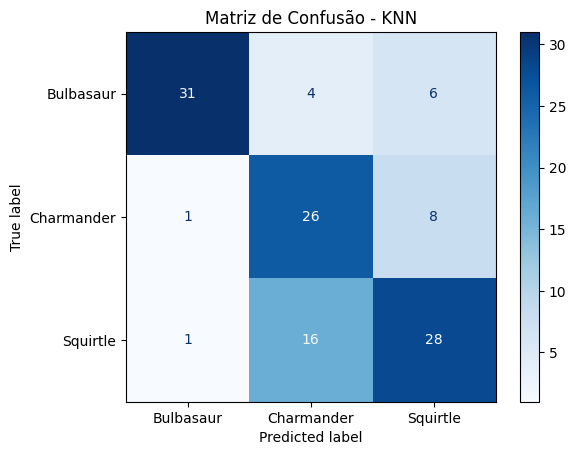

In [19]:
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Carregar dados de teste
test_df = pd.read_csv("./data/Valid/combined_features.csv")
X_test = test_df.drop('class', axis=1)
y_test = le.transform(test_df['class'])

# Melhor modelo KNN
best_knn = grid_knn.best_estimator_

# Predição e avaliação
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nAcurácia no conjunto de teste: {acc:.4f}")

print("\nRelatório de Classificação (Teste):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - KNN')
plt.show()

### 4.2 Treinamento e Avaliação do SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Pipeline para SVM
svm_pipeline = make_pipeline(
    StandardScaler(),
    PCA(),
    SMOTE(random_state=42),
    SVC(probability=True)
)

# Distribuições de parâmetros para busca aleatória
param_dist = {
    'pca__n_components': [50, 100, 150, None],
    'svc__C': loguniform(1e-3, 1e3),
    'svc__gamma': loguniform(1e-3, 1e3),
    'svc__kernel': ['rbf', 'linear', 'poly'],
    'svc__degree': [2, 3, 4],
    'svc__class_weight': [None, 'balanced']
}

# Busca aleatória com validação cruzada
random_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_svm.fit(X_train, y_train_encoded)

# Resultados
print("Melhores parâmetros SVM:")
print(random_svm.best_params_)
print(f"Melhor F1-score: {random_svm.best_score_:.4f}")

# Avaliação cruzada
svm_scores = cross_val_score(
    random_svm.best_estimator_,
    X_train,
    y_train_encoded,
    cv=5,
    scoring='f1_macro'
)
print(f"Scores de validação cruzada (Acurácia): {svm_scores}")
print(f"Média Acurácia: {np.mean(svm_scores):.4f} (±{np.std(svm_scores):.4f})")

Fitting 5 folds for each of 50 candidates, totalling 250 fits



Relatório de Classificação - SVM (Teste):
              precision    recall  f1-score   support

   Bulbasaur       0.80      0.90      0.85        41
  Charmander       0.81      0.74      0.78        35
    Squirtle       0.84      0.80      0.82        45

    accuracy                           0.82       121
   macro avg       0.82      0.82      0.81       121
weighted avg       0.82      0.82      0.82       121


Matriz de Confusão - SVM:


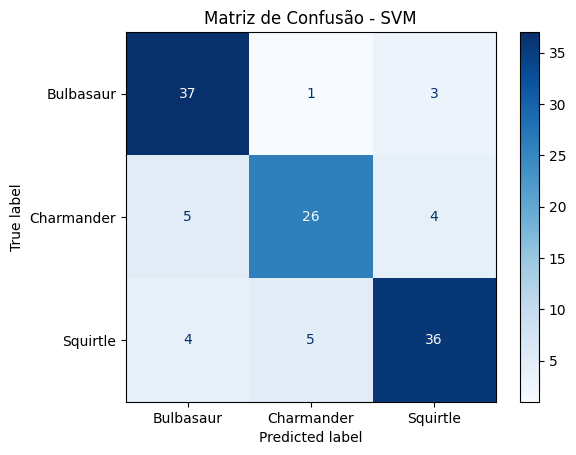

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Melhor modelo SVM
best_svm = random_svm.best_estimator_

# Predição e avaliação
y_pred_svm = best_svm.predict(X_test)

print("\nRelatório de Classificação - SVM (Teste):")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

print("\nMatriz de Confusão - SVM:")
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - SVM')
plt.show()

### 4.3 Treinamento e Avaliação da Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Pipeline para Árvore de Decisão
tree_pipeline = make_pipeline(
    StandardScaler(),
    SMOTE(random_state=42),
    BaggingClassifier(
        DecisionTreeClassifier(),
        n_estimators=10,
        random_state=42
    )
)

# Grade de parâmetros
tree_params = {
    'baggingclassifier__estimator__criterion': ['gini', 'entropy'],
    'baggingclassifier__estimator__max_depth': [None, 10, 20, 30],
    'baggingclassifier__estimator__min_samples_split': [2, 5, 10],
    'baggingclassifier__estimator__min_samples_leaf': [1, 2, 4],
    'baggingclassifier__estimator__max_features': ['sqrt', 'log2', None],
    'baggingclassifier__estimator__class_weight': [None, 'balanced']
}

# Busca em grade
grid_tree = GridSearchCV(
    tree_pipeline,
    tree_params,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_tree.fit(X_train, y_train_encoded)

# Resultados
print("Melhores parâmetros Árvore de Decisão:")
print(grid_tree.best_params_)
print(f"Melhor F1-score: {grid_tree.best_score_:.4f}")

# Avaliação cruzada
tree_scores = cross_val_score(
    grid_tree.best_estimator_,
    X_train,
    y_train_encoded,
    cv=5,
    scoring='f1_macro'
)
print(f"Scores de validação cruzada: {tree_scores}")
print(f"Média F1-score: {np.mean(tree_scores):.4f} (±{np.std(tree_scores):.4f})")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Melhores parâmetros Árvore de Decisão:
{'baggingclassifier__estimator__class_weight': None, 'baggingclassifier__estimator__criterion': 'gini', 'baggingclassifier__estimator__max_depth': 10, 'baggingclassifier__estimator__max_features': 'sqrt', 'baggingclassifier__estimator__min_samples_leaf': 2, 'baggingclassifier__estimator__min_samples_split': 2}
Melhor F1-score: 0.8573
Scores de validação cruzada: [0.88374264 0.81943667 0.84027843 0.81836122 0.92451499]
Média F1-score: 0.8573 (±0.0411)



Relatório de Classificação - Árvore (Teste):
              precision    recall  f1-score   support

   Bulbasaur       0.84      0.90      0.87        41
  Charmander       0.63      0.69      0.66        35
    Squirtle       0.79      0.69      0.74        45

    accuracy                           0.76       121
   macro avg       0.76      0.76      0.76       121
weighted avg       0.76      0.76      0.76       121


Matriz de Confusão - Árvore:


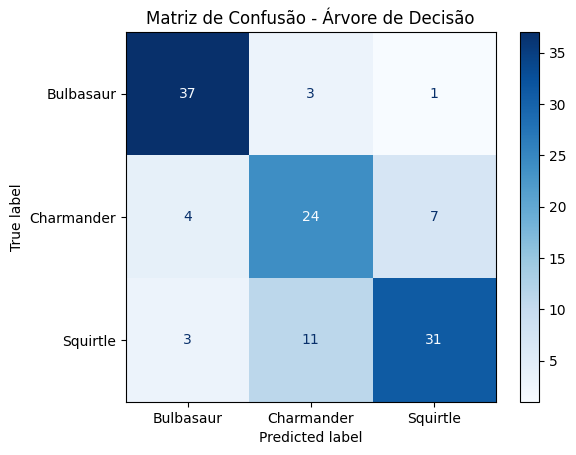

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Melhor modelo de Árvore
best_tree = grid_tree.best_estimator_

# Predição e avaliação
y_pred_tree = best_tree.predict(X_test)

print("\nRelatório de Classificação - Árvore (Teste):")
print(classification_report(y_test, y_pred_tree, target_names=le.classes_))

print("\nMatriz de Confusão - Árvore:")
cm_tree = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.show()